In [3]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.sparse import linalg as LA 
from scipy import sparse as sp
%matplotlib inline

In [34]:
def one_dim_step(u_0, left, right, K, tau, h, epsilon, max_iterations):
    u_prev = u_0.copy()
    converged = False
    N = u_0.size - 1
    iteration = 0
    # F = u_0[1:-1]
    def a(y):
        return K((y[:-1] + y[1:]) / 2)
    F = tau / (2 * h**2) * (a(u_0)[1:] * (u_0[2:] - u_0[1:-1]) - a(u_0)[:-1] * (u_0[1:-1] - u_0[:-2])) + u_0[1:-1]

    while not converged:
        iteration += 1
        if iteration > max_iterations:
            #print('iteration stop')
            break

        A = tau / (2 * h**2) * a(u_prev)
        
        main_diag = np.hstack((1, -(A[1:] + A[:-1] + 1), 1))
        upper_diag = np.hstack((0, A[1:]))
        under_diag = np.hstack((A[:-1], 0))

        L = sp.diags([main_diag, upper_diag, under_diag], [0, 1, -1], (N+1, N+1), format='csr')
        # u_new = LA.spsolve(L, np.hstack((left, -u_0[1:-1], right)))
        u_new = LA.cg(L, np.hstack((left, -F, right)), np.hstack((left, u_prev[1:-1], right)))[0]

        if np.max(np.abs(u_new - u_prev)) < epsilon:
            #print('converged on', iteration)
            converged = True
        
        u_prev = u_new

    return u_prev

def one_dim_solve(u_0, t_end, K, mu_l, mu_r, tau, h, epsilon=1e-9, max_iterations=20):
    N_t = int(np.round(t_end / tau))
    tau = t_end / N_t
    u = u_0.copy()

    for j in range(1, N_t + 1):
        u = one_dim_step(u, mu_l(j * tau), mu_r(j * tau), K, tau, h, epsilon, max_iterations)
    
    return u

In [36]:
kappa_0 = 0.5
sigma = 2
c = 0.1125
x_1 = 0.5
t_0 = 0.1

def u(x, t):
    return ((sigma * (x_1 - x) ** 2) / (2 * kappa_0 * (sigma + 2) * (c - t)) * np.heaviside(x_1 - x, 0)) ** (1 / sigma)

def mu_l(t):
    return 1 / np.sqrt(0.9 - 8 * (t + t_0))

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * (u ** sigma)

N = 50
x_end = 1.0
x = np.linspace(0, x_end, N+1)
h = x_end / N
tau = 1e-4

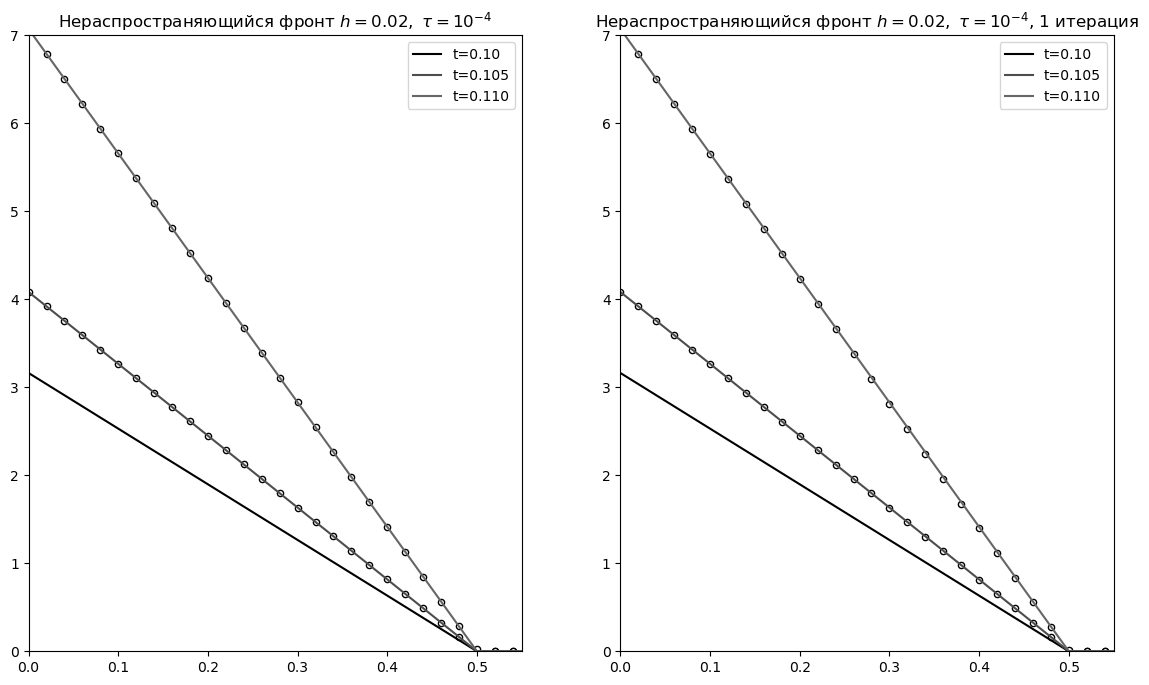

In [18]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121)
ax1.plot(x, u(x, t_0), color='0', label='t=0.10')
ax1.plot(x, u(x, 0.105), color='0.3', label='t=0.105')
ax1.plot(x, u(x, 0.110), color='0.4', label='t=0.110')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.scatter(x, one_dim_solve(u(x, t_0), 0.105 - t_0, K, mu_l, mu_r, tau, h), c='1', edgecolors='0', s=20)
ax1.scatter(x, one_dim_solve(u(x, t_0), 0.110 - t_0, K, mu_l, mu_r, tau, h), c='1', edgecolors='0', s=20)

ax1.set_ylim(0, 7)
ax1.set_yticks(range(0, 8))
ax1.set_xlim(0, 0.55)
ax1.legend()
ax1.set_title("Нераспространяющийся фронт $h = 0.02, \\ \\tau = 10^{-4}$")

ax2 = fig.add_subplot(122)
ax2.plot(x, u(x, t_0), color='0', label='t=0.10')
ax2.plot(x, u(x, 0.105), color='0.3', label='t=0.105')
ax2.plot(x, u(x, 0.110), color='0.4', label='t=0.110')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.scatter(x, one_dim_solve(u(x, t_0), 0.105 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, one_dim_solve(u(x, t_0), 0.110 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1), c='1', edgecolors='0', s=20)

ax2.set_ylim(0, 7)
ax2.set_yticks(range(0, 8))
ax2.set_xlim(0, 0.55)
ax2.legend()
ax2.set_title("Нераспространяющийся фронт $h = 0.02, \\ \\tau = 10^{-4}$, 1 итерация")

plt.show()

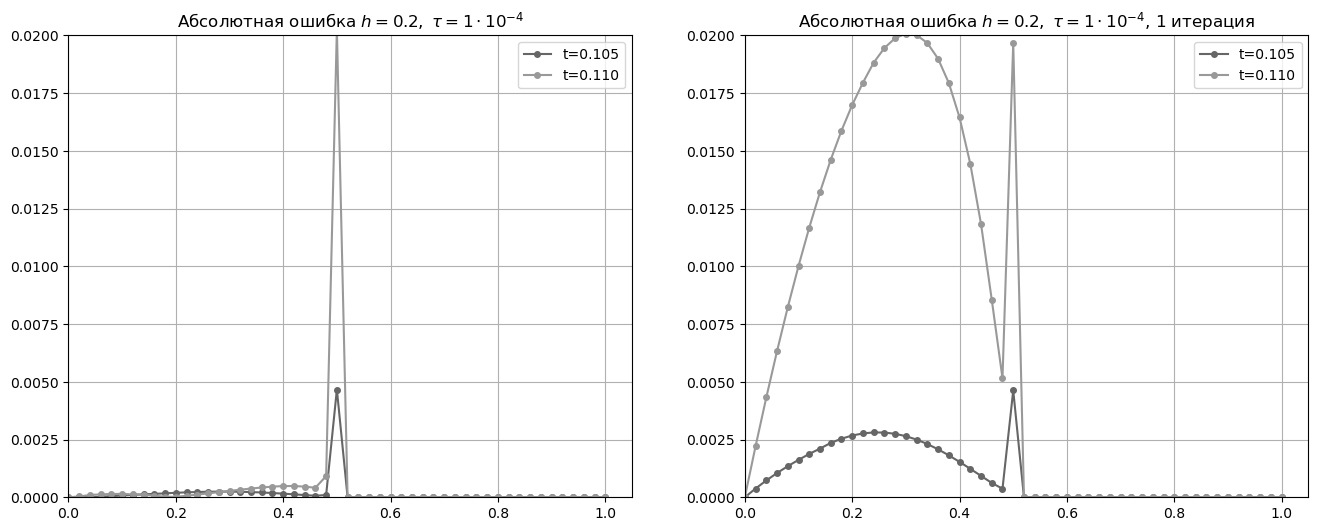

In [19]:
top = 0.02
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.plot(x, np.abs(u(x, 0.105) - one_dim_solve(u(x, t_0), 0.105 - t_0, K, mu_l, mu_r, tau, h)), color='0.4', label='t=0.105', marker='o', ms=4)
ax1.plot(x, np.abs(u(x, 0.110) - one_dim_solve(u(x, t_0), 0.110 - t_0, K, mu_l, mu_r, tau, h)), color='0.6', label='t=0.110', marker='o', ms=4)

ax1.set_ylim(0, top)
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 1\\cdot 10^{-4}$")
ax1.grid(True)

ax2 = fig.add_subplot(122)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.plot(x, np.abs(u(x, 0.105) - one_dim_solve(u(x, t_0), 0.105 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1)), color='0.4', label='t=0.105', marker='o', ms=4)
ax2.plot(x, np.abs(u(x, 0.110) - one_dim_solve(u(x, t_0), 0.110 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1)), color='0.6', label='t=0.110', marker='o', ms=4)

ax2.set_ylim(0, top)
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 1\\cdot 10^{-4}$, 1 итерация")
ax2.grid(True)

plt.show()

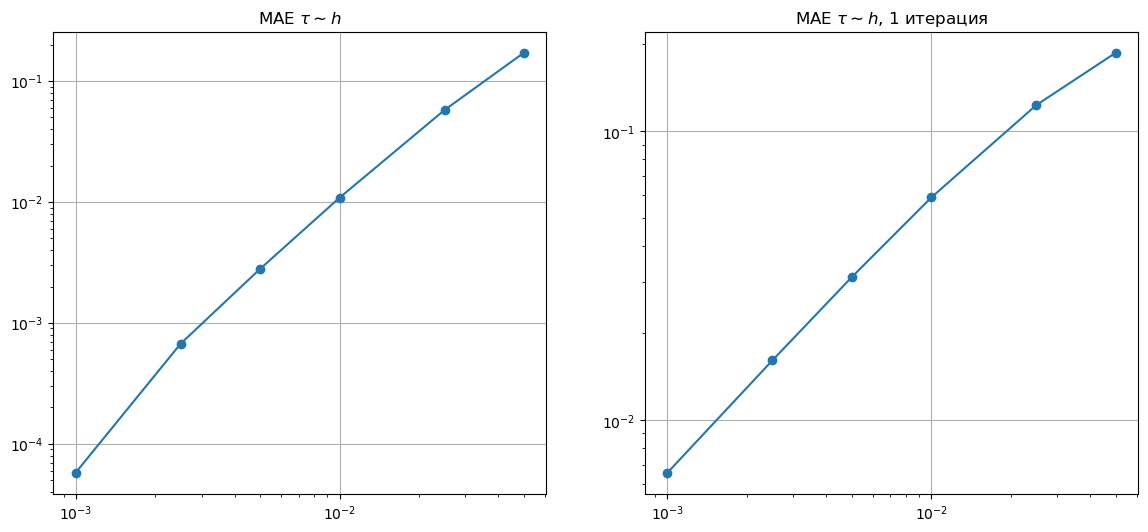

In [45]:
h_steps = np.array([0.05, 0.025, 0.01, 0.005, 0.0025, 0.001])
err = []
err_1 = []

for h_i in h_steps:
    x_i = np.linspace(0, 1, int(1 / h_i)+1)
    err.append(np.mean(np.abs(u(x_i, 0.11) - one_dim_solve(u(x_i, t_0), 0.11 - t_0, K, mu_l, mu_r, h_i / 10, h_i))))
    err_1.append(np.mean(np.abs(u(x_i, 0.11) - one_dim_solve(u(x_i, t_0), 0.11 - t_0, K, mu_l, mu_r, h_i / 10, h_i, max_iterations=1))))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.loglog(h_steps, err, marker='o')
ax1.set_title("MAE $\\tau \\sim h$")
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.loglog(h_steps, err_1, marker='o')
ax2.set_title("MAE $\\tau \\sim h$, 1 итерация")
ax2.grid(True)

plt.show()

In [46]:
kappa_0 = 0.5
sigma = 2
c = 5
x_1 = 0
t_0 = 0.1

def u(x, t):
    return ((sigma * c / kappa_0 * (c * t + x_1 - x)) * np.heaviside(x_1 + c*t - x, 0)) ** (1 / sigma)

# добавим t_0, чтобы за t передавалось относительное время внутри решателя
def mu_l(t):
    return 10 * np.sqrt(t + t_0)

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * u ** sigma

N = 50
x = np.linspace(0, 1, N + 1)
h = 1 / N
tau =  2e-4

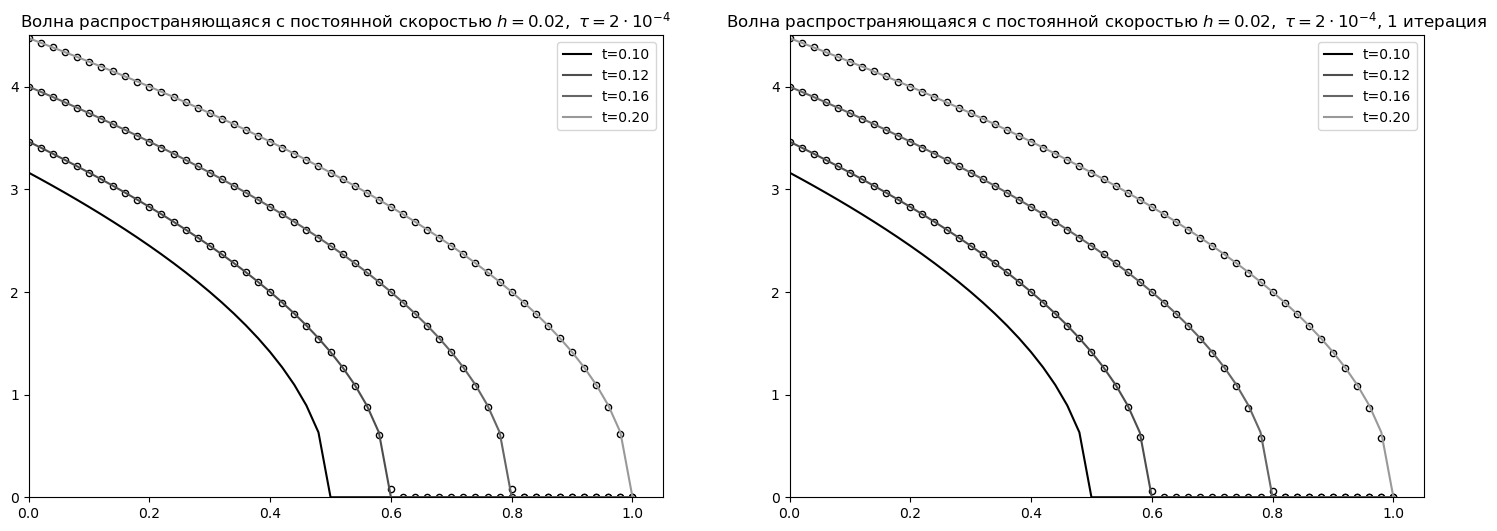

In [22]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax1.plot(x, u(x, t_0), color='0', label='t=0.10')
ax1.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax1.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax1.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.scatter(x, one_dim_solve(u(x, t_0), 0.12 - t_0, K, mu_l, mu_r, tau, h), c='1', edgecolors='0', s=20)
ax1.scatter(x, one_dim_solve(u(x, t_0), 0.16 - t_0, K, mu_l, mu_r, tau, h), c='1', edgecolors='0', s=20)
ax1.scatter(x, one_dim_solve(u(x, t_0), 0.20 - t_0, K, mu_l, mu_r, tau, h), c='1', edgecolors='0', s=20)

ax1.set_ylim(0, 4.5)
ax1.set_yticks(range(0, 5))
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Волна распространяющаяся с постоянной скоростью $h = 0.02, \\ \\tau = 2\\cdot 10^{-4}$")

ax2 = fig.add_subplot(122)
ax2.plot(x, u(x, t_0), color='0', label='t=0.10')
ax2.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
ax2.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
ax2.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.scatter(x, one_dim_solve(u(x, t_0), 0.12 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, one_dim_solve(u(x, t_0), 0.16 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1), c='1', edgecolors='0', s=20)
ax2.scatter(x, one_dim_solve(u(x, t_0), 0.20 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1), c='1', edgecolors='0', s=20)

ax2.set_ylim(0, 4.5)
ax2.set_yticks(range(0, 5))
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Волна распространяющаяся с постоянной скоростью $h = 0.02, \\ \\tau = 2\\cdot 10^{-4}$, 1 итерация")

plt.show()

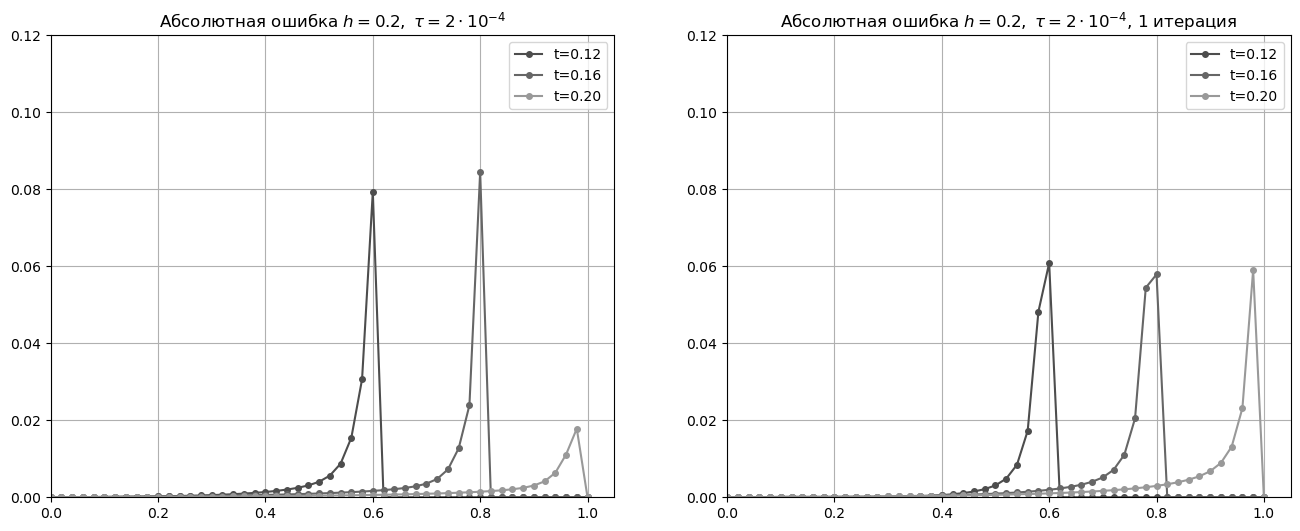

In [23]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax1.plot(x, np.abs(u(x, 0.12) - one_dim_solve(u(x, t_0), 0.12 - t_0, K, mu_l, mu_r, tau, h)), color='0.3', label='t=0.12', marker='o', ms=4)
ax1.plot(x, np.abs(u(x, 0.16) - one_dim_solve(u(x, t_0), 0.16 - t_0, K, mu_l, mu_r, tau, h)), color='0.4', label='t=0.16', marker='o', ms=4)
ax1.plot(x, np.abs(u(x, 0.20) - one_dim_solve(u(x, t_0), 0.20 - t_0, K, mu_l, mu_r, tau, h)), color='0.6', label='t=0.20', marker='o', ms=4)

ax1.set_ylim(0, 0.12)
ax1.set_xlim(0, 1.05)
ax1.legend()
ax1.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 2\\cdot 10^{-4}$")
ax1.grid(True)

ax2 = fig.add_subplot(122)

# Вычитаю t_0, потому что в решателе время отностиельное (относительно начала отсчета)
ax2.plot(x, np.abs(u(x, 0.12) - one_dim_solve(u(x, t_0), 0.12 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1)), color='0.3', label='t=0.12', marker='o', ms=4)
ax2.plot(x, np.abs(u(x, 0.16) - one_dim_solve(u(x, t_0), 0.16 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1)), color='0.4', label='t=0.16', marker='o', ms=4)
ax2.plot(x, np.abs(u(x, 0.20) - one_dim_solve(u(x, t_0), 0.20 - t_0, K, mu_l, mu_r, tau, h, max_iterations=1)), color='0.6', label='t=0.20', marker='o', ms=4)

ax2.set_ylim(0, 0.12)
ax2.set_xlim(0, 1.05)
ax2.legend()
ax2.set_title("Абсолютная ошибка $h = 0.2, \\ \\tau = 2\\cdot 10^{-4}$, 1 итерация")
ax2.grid(True)

plt.show()

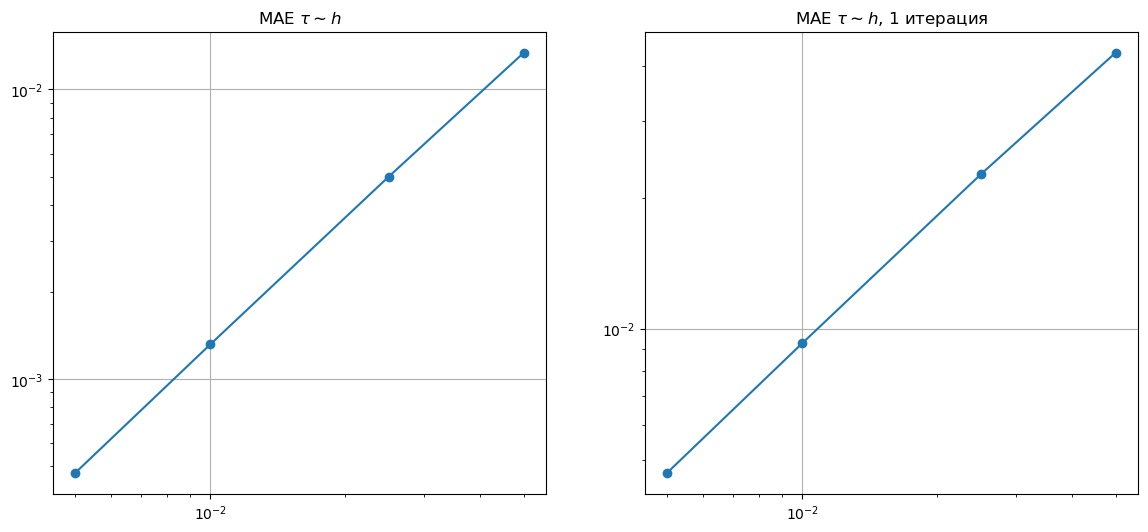

In [50]:
h_steps = np.array([0.05, 0.025, 0.01, 0.005])
err = []
err_1 = []

for h_i in h_steps:
    x_i = np.linspace(0, 1, int(1 / h_i)+1)
    err.append(np.mean(np.abs(u(x_i, 0.18) - one_dim_solve(u(x_i, t_0), 0.18 - t_0, K, mu_l, mu_r, h_i / 10, h_i))))
    err_1.append(np.mean(np.abs(u(x_i, 0.18) - one_dim_solve(u(x_i, t_0), 0.18 - t_0, K, mu_l, mu_r, h_i / 10, h_i, max_iterations=1))))

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.loglog(h_steps, err, marker='o')
ax1.set_title("MAE $\\tau \\sim h$")
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.loglog(h_steps, err_1, marker='o')
ax2.set_title("MAE $\\tau \\sim h$, 1 итерация")
ax2.grid(True)

plt.show()